# AML: Homework 5

**Authors:**
- Timotius Kartawijaya (tak2151)
- Jing Yi Zhou (jyz2111)

In [1]:
import pandas as pd
import random
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Input, BatchNormalization, Dense, Dropout, Activation, Flatten, InputLayer, Conv2D, MaxPooling2D
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from keras import regularizers
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from glob import glob
import matplotlib.pyplot as plt
import cv2
import fnmatch
import random
import os
from tqdm import tqdm_notebook as tqdm
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


# Task 1

First, let's load the data and split it into train/test splits. 

In [0]:
load = load_iris()
X = load.data
y = load.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
num_classes = 3 

Next, let's take a peek at the dataset.

In [0]:
X_train.shape

(105, 4)

In [0]:
X_train[:5,:]

array([[5.1, 2.5, 3. , 1.1],
       [6.2, 2.2, 4.5, 1.5],
       [5.1, 3.8, 1.5, 0.3],
       [6.8, 3.2, 5.9, 2.3],
       [5.7, 2.8, 4.1, 1.3]])

In [0]:
y_train

array([1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 2,
       2, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 2, 0, 2, 0,
       2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2,
       2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2,
       2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0])

In [0]:
pd.Series(y).value_counts()

2    50
1    50
0    50
dtype: int64

From our first look above, we know that:
1. Our dataset is balanced. No need to take account of imbalance.
2. We need to normalize our data.
3. We need to one-hot-encode/preprocess our y values. 

## Preprocessing

In [0]:
y_test_original = y_test.copy()

# PREPROCESSING
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Normalizer doesn't leak information, so need of pipelines.
scaler = Normalizer() # scale dataset 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create our stratifier
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

## Model Selection
Next, let's create a Neural Network  with two hidden layers and wrap in sklearn to effectively grid search for the best regularization parameter and sizes of the hidden layers.

In [0]:
def baseline_model(optimizer="adam", hidden_size=32, l2_param=0.01):
    model = Sequential([
        Dense(hidden_size, input_shape=(4,), activation='relu', kernel_regularizer=regularizers.l2(l2_param)),
        Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(l2_param)),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

split = sss.split(X_train, y_train)

clf = KerasClassifier(baseline_model, epochs=30)
param_grid = {'hidden_size': [32, 64, 256, 512],
              'l2_param': [0, 0.005, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=split)
base_history = grid.fit(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_592 (Dense)            (None, 32)                160       
_________________________________________________________________
dense_593 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_594 (Dense)            (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
73/73 [==============================] - 16s 218ms/step - loss: 1.1036 - acc: 0.2192
Epoch 2/30
73/73 [==============================] - 0s 284us/step - loss: 1.0897 - acc: 0.4247
Epoch 3/30
73/73 [==============================] - 0s 282us/step - loss: 1.0811 - acc: 0.6986
Epoch 4/30
73/73 [==============================] - 0s 273us/step - loss: 1.0727 - acc: 0.8356
Epoch 5/30
73/73 [=====

## Grid Search Result and Evaluation on Test Set
Now that we've completed fitting, let us see how our model performed. From the results below, we see that the grid search were able to find the best parameters and the best model performed well in the (96.8% accuracy on validation set and 100% accuracy on test set with the best model!). From the table below, we can see that with a much larger layer have results that are the same as a smaller neural network (512 vs. 256). Thus, we can use the smaller without loss of accuracy. The accuracy is very high probably due to the small size of the test set since the dataset is only 150 rows and the common knowledge that the iris dataset is predictable.

In [0]:
from sklearn.metrics import accuracy_score, f1_score
print('Best CV score: ', grid.best_score_)
y_pred = grid.predict(X_test)
print('Test Set Accuracy Score: ', accuracy_score(y_test_original, y_pred))
print('Test Set F1 Score: ', f1_score(y_test_original, y_pred, average='macro'))
print('Best Params: ', grid.best_params_)


Best CV score:  0.96875
Test Case Accuracy Score:  1.0
Test Case F1 Score:  1.0
Best Params:  {'hidden_size': 256, 'l2_param': 0}


In [0]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_hidden_size","param_l2_param"],
               values=["mean_train_score", "mean_test_score"])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


mean_test_score  mean_train_score
param_hidden_size param_l2_param                                   
32                0.000                   0.75000          0.808219
                  0.005                   0.65625          0.671233
                  0.010                   0.68750          0.684932
                  0.100                   0.65625          0.671233
                  1.000                   0.65625          0.671233
                  10.000                  0.65625          0.671233
64                0.000                   0.81250          0.794521
                  0.005                   0.90625          0.917808
                  0.010                   0.65625          0.671233
                  0.100                   0.62500          0.712329
                  1.000                   0.59375          0.671233
                  10.000                  0.31250          0.342466
256               0.000                   0.96875          0.945205
                  0.005                   0.81250          0.876712
                  0.010                   0.78125          0.780822
                  0.100                   0.65625          0.671233
                  1.000                   0.31250          0.383562
                  10.000                  0.56250          0.520548
512               0.000                   0.96875          0.945205
                  0.005                   0.96875          0.958904
                  0.010                   0.96875          0.945205
                  0.100                   0.65625          0.671233
                  1.000                   0.34375          0.328767
                  10.000                  0.31250          0.342466

# Task 2

Next, let us train a fully connected multilayer perceptron on the Fashion MNIST datset. First, let's load the data and take a look at the data.

In [0]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_data shape: (60000, 28, 28)


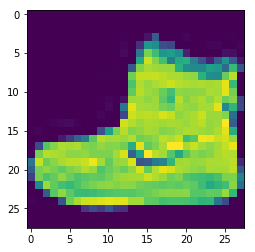

In [0]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])
print('X_data shape:', X_train.shape)

In [0]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [0]:
pd.Series(y_train).value_counts() # dataset is balanced

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

From the results above we can see that:
1. Our data consists of images of clothingwith 28x28 dimensions. 
2. We have a multi-class classification problem (10 classes). Even so, our dataset is balanced. 
3. We would need to normalize our data as above. 

## Preprocessing

On top of preprocessing, let's split the training data further and obtain 10,000 rows as our validation set (for model selection, we would be using trial/error rather than GridSearch due to training time). 

In [0]:
# normalize data, 255 is sum since its pixels
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

num_classes = 10
img_rows, img_cols = 28, 28

X_train_original = X_train.copy()
X_train_original = X_train_original.reshape(X_train_original.shape[0], img_rows, img_cols, 1)
y_train_original = to_categorical(y_train, num_classes)


# split further for train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=10000/60000.0, random_state=42)

# reshape properly for NN input
X_train_reshaped = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

# one hot encode
y_train_onehot = to_categorical(y_train, num_classes)
y_val_onehot = to_categorical(y_val, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

## Model Selection
For this task, we will compare a few models:
1. Baseline/"Vanilla" Model (2 Layers)
2. Model with Drop-Out (Deeper + Larger)
3. Model with Batch Normalization and Residual Connections


### Baseline Model

For our baseline model, we will only use 2 Layers and regularization (similar to Task 1). Since GridSearchCV would take too long, we would do sequential trial/error (using for loops one parameter at a time) to find the best parameter. In reality, it would be better to do GridSearchCV, but since we don't have the resources we would have to make do with trial/error.

In [0]:
def baseline_model_fashion(optimizer="adam", hidden_size=32, l2_param=0.01, summary=True):
    model = Sequential()
    model.add(InputLayer(input_shape = (28, 28, 1)))
    model.add(Dense(hidden_size, activation = 'relu', kernel_regularizer=regularizers.l2(l2_param)))
    model.add(Dense(hidden_size, activation = 'relu', kernel_regularizer=regularizers.l2(l2_param)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    if summary:
      model.summary()
    return model

def get_best_param(params, model_builder, param_name, other_param=None, X=X_train_reshaped, y=y_train_onehot, X_val=X_val_reshaped, y_val=y_val_onehot, verbose=0, summary=False):
  loss_res = []
  score_res = []
  for param in params:
    if param_name == 'size':
      model = model_builder(hidden_size=param, summary=summary)
    elif param_name == 'l2':
      model = model_builder(l2_param=param, hidden_size=other_param, summary=summary)
    else:
      print('no such parameter')
      break
    model.fit(X, y, batch_size=128, epochs=30, verbose=verbose)
    score = model.evaluate(X_val, y_val)
    loss_res.append(score[0])
    score_res.append(score[1])
    print("Hidden Size: ", param)
    print("Validation loss: ", score[0])
    print("Validation accuracy: ", score[1])
  best_size = params[np.argsort(score_res)[::-1][0]]
  plt.plot(params, score_res)
  return best_size

10000/10000 [==============================] - 14s 1ms/step
Hidden Size:  32
Validation loss:  0.377350839972496
Validation accuracy:  0.8801
10000/10000 [==============================] - 14s 1ms/step
Hidden Size:  64
Validation loss:  0.3748730644464493
Validation accuracy:  0.8801
10000/10000 [==============================] - 14s 1ms/step
Hidden Size:  256
Validation loss:  0.374734585237503
Validation accuracy:  0.8818


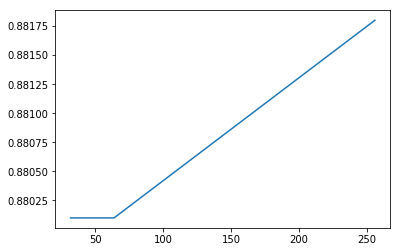

In [0]:
# PARAM SIZE SEARCH 
hidden_size_params = [32, 64, 256]
best_size_base = get_best_param(hidden_size_params, baseline_model_fashion, 'size')

10000/10000 [==============================] - 1s 58us/step
Hidden Size:  0
Validation loss:  0.34179021987915037
Validation accuracy:  0.8824
10000/10000 [==============================] - 1s 62us/step
Hidden Size:  0.01
Validation loss:  0.3847651903629303
Validation accuracy:  0.8757
10000/10000 [==============================] - 1s 65us/step
Hidden Size:  0.1
Validation loss:  0.4477887538909912
Validation accuracy:  0.8686


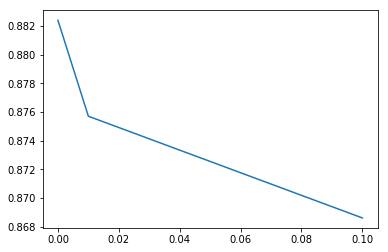

In [0]:
best_size_base = 32 # not much difference so stick with smallest for performance sake

# L2 PARAM SEARCH
l2_params = [0, 0.01, 0.1]
best_l2_base = get_best_param(l2_params, baseline_model_fashion, 'l2', best_size_base)

#### Train/Test of Best Model 

In [0]:
best_base = baseline_model_fashion(hidden_size = 32, l2_param = 0)
baseline_fashion_callback = best_base.fit(X_train_reshaped, y_train_onehot, batch_size=128, epochs=30, verbose=1)
score = best_base.evaluate(X_val_reshaped, y_val_onehot)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 28, 28, 32)        64        
_________________________________________________________________
dense_20 (Dense)             (None, 28, 28, 32)        1056      
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                250890    
Total params: 252,010
Trainable params: 252,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50000/50000 [==============================] - 3s 66us/step - loss: 0.5476 - acc: 0.8103
Epoch 2/30
50000/50000 [==============================] - 3s 52us/step - loss: 0.4098 - acc: 0.8561
Epoch 3/30
50000/50000 [==============================] - 3s 53us/st

#### Learning Curve of Best Model

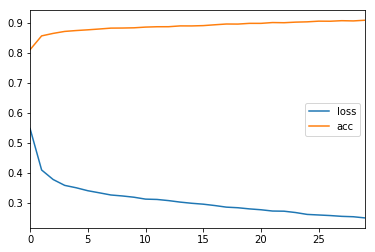

In [0]:
pd.DataFrame(baseline_fashion_callback.history).plot()

## Model with Dropout


Next, we will try a model with dropout, where we introduce dropout regularization and a bigger neural network. Let's see if this will make any changes to the results.

In [0]:
from keras.layers import Dropout

def dropout_model_fashion(optimizer="adam", hidden_size=512, l2_param=0.01, summary=False):
    model = Sequential()
    model.add(InputLayer(input_shape = (28, 28, 1)))
    model.add(Dense(hidden_size, activation = 'relu', kernel_regularizer=regularizers.l2(l2_param)))
    model.add(Dropout(.5))
    model.add(Dense(hidden_size, activation = 'relu', kernel_regularizer=regularizers.l2(l2_param)))
    model.add(Dropout(.5))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    if summary:
      model.summary()
    return model


Using TensorFlow backend.


In [0]:
# PARAM SIZE SEARCH 
# 64: 86%
# 256: 87.6%
# 512: 87.98%
hidden_size_params = [512]  #
best_size_dropout = get_best_param(hidden_size_params, dropout_model_fashion, 'size', verbose=1, summary=True)

10000/10000 [==============================] - 3s 297us/step
Hidden Size:  0
Validation loss:  0.372774368417263
Validation accuracy:  0.8729
10000/10000 [==============================] - 3s 303us/step
Hidden Size:  0.1
Validation loss:  0.4064015640258789
Validation accuracy:  0.8763
10000/10000 [==============================] - 3s 306us/step
Hidden Size:  1
Validation loss:  0.5326793508052826
Validation accuracy:  0.8522


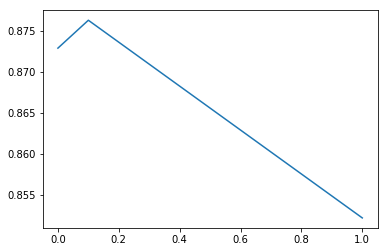

In [0]:
# L2 PARAM SEARCH
best_size_dropout = 512
l2_params = [0, 0.1, 1]
best_l2_dropout = get_best_param(l2_params, dropout_model_fashion, 'l2', best_size_dropout)

#### Train/Test of Best Model

In [0]:
best_dropout = dropout_model_fashion(hidden_size = 512, l2_param = 0.1)
dropout_fashion_callback = best_dropout.fit(X_train_reshaped, y_train_onehot, batch_size=128, epochs=30, verbose=1)
score = best_dropout.evaluate(X_val_reshaped, y_val_onehot)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
50000/50000 [==============================] - 48s 958us/step - loss: 3.4946 - acc: 0.8020
Epoch 2/30
50000/50000 [==============================] - 48s 952us/step - loss: 0.5328 - acc: 0.8417
Epoch 3/30
50000/50000 [==============================] - 47s 950us/step - loss: 0.5130 - acc: 0.8455
Epoch 4/30
50000/50000 [==============================] - 47s 949us/step - loss: 0.4997 - acc: 0.8504
Epoch 5/30
50000/50000 [==============================] - 47s 948us/step - loss: 0.4899 - acc: 0.8537
Epoch 6/30
50000/50000 [==============================] - 47s 946us/step - loss: 0.4810 - acc: 0.8558
Epoch 7/30
50000/50000 [==============================] - 47s 946us/step - loss: 0.4742 - acc: 0.8574
Epoch 8/30
50000/50000 [==============================] - 47s 945us/step - loss: 0.4696 - acc: 0.8582
Epoch 9/30
50000/50000 [==============================] - 47s 946us/step - loss: 0.4631 - acc: 0.8612
Epoch 10/30
50000/50000 [=========

#### Learning Curve

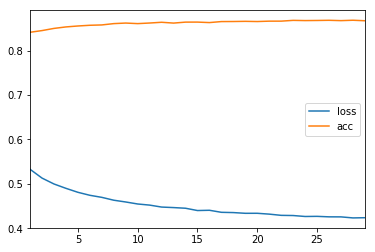

In [0]:
pd.DataFrame(dropout_fashion_callback.history)[1:].plot()

## Model with Batch Normalization and Residual Connections (without dropout)

Finally, let's try a model with batch normalization and residual connections and see if our metrics improve. 

In [0]:
def batch_model_fashion(optimizer="adam", hidden_size=32, l2_param=0.01, summary=True):
    inputs = Input(shape = (28, 28, 1))
    
    layer_1 = Dense(hidden_size, activation = 'relu', kernel_regularizer=regularizers.l2(l2_param))(inputs)
    layer_1 = BatchNormalization()(layer_1)
    
    layer_2 = Dense(hidden_size, activation = 'relu', kernel_regularizer=regularizers.l2(l2_param))(layer_2)
    layer_2 = BatchNormalization()(layer_2)
    
    skip = keras.layers.add([layer_1, layer_2])
    
    x = Flatten()(skip)
    predictions = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    if summary:
      model.summary()
    return model

10000/10000 [==============================] - 1s 105us/step
Hidden Size:  32
Validation loss:  0.49896108491420743
Validation accuracy:  0.8553
10000/10000 [==============================] - 1s 130us/step
Hidden Size:  64
Validation loss:  0.4199284671425819
Validation accuracy:  0.8703
10000/10000 [==============================] - 2s 243us/step
Hidden Size:  256
Validation loss:  7.13221257019043
Validation accuracy:  0.5547
10000/10000 [==============================] - 1s 143us/step
Hidden Size:  0
Validation loss:  0.785753148651123
Validation accuracy:  0.8023
10000/10000 [==============================] - 2s 152us/step
Hidden Size:  0.1
Validation loss:  0.493877357006073
Validation accuracy:  0.8637
10000/10000 [==============================] - 2s 158us/step
Hidden Size:  1
Validation loss:  0.4026901068687439
Validation accuracy:  0.8686


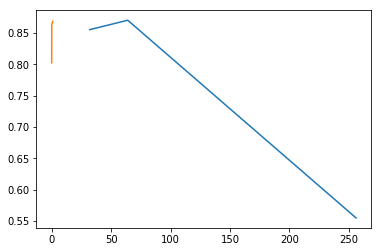

In [0]:
# PARAM SIZE SEARCH 
hidden_size_params = [32, 64, 256]
best_size_batch = get_best_param(hidden_size_params, batch_model_fashion, 'size')

# L2 PARAM SEARCH
l2_params = [0, 0.1, 1]
best_l2_batch = get_best_param(l2_params, batch_model_fashion, 'l2', best_size_batch)

#### Train/Test of Best Model

In [0]:
best_batch = batch_model_fashion(hidden_size = 64, l2_param = 1)
batch_fashion_callback = best_batch.fit(X_train_reshaped, y_train_onehot, batch_size=128, epochs=30, verbose=1)
score = best_batch.evaluate(X_val_reshaped, y_val_onehot)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
dense_7 (Dense)              (None, 28, 28, 64)        128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dense_8 (Dense)              (None, 28, 28, 64)        4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                501770    
Total para

#### Learning Curve

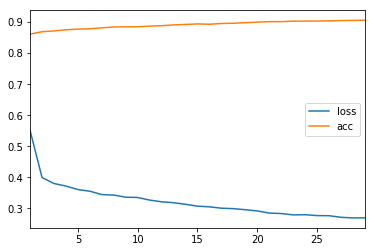

In [0]:
pd.DataFrame(batch_fashion_callback.history)[1:].plot()

## Conclusion / Best Model Performance on Test Set

Our baseline model turned out to be the best model, with 88% accuracy. All the models above display a good learning curve, since the model was able to minimize loss in a more steady rate with more epochs done. Batch Normalization and Residual Connections / Dropout didn't improve the validation results significantly, reaching similar levels of ~88% accuracy. Therefore, we conclude that the baseline model is the best model at this point for our prediction. We will evaluate said best model with the test set.

In [0]:
best_base = baseline_model_fashion(hidden_size = 32, l2_param = 0)
baseline_fashion_callback = best_base.fit(X_train_original, y_train_original, batch_size=128, epochs=30, verbose=1)
score = best_base.evaluate(X_test, y_test_onehot)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
dense_5 (Dense)              (None, 28, 28, 32)        1056      
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                250890    
Total params: 252,010
Trainable params: 252,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
60000/60000 [==============================] - 3s 57us/step - loss: 0.5229 - acc: 0.8183
Epoch 2/30
60000/60000 [==============================] - 3s 51us/step - loss: 0.3873 - acc: 0.8621
Epoch 3/30
60000/60000 [==============================] - 3s 51us/st

In [0]:
score = best_base.evaluate(X_test, y_test)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

# Task 3

In this task, we will train a convolutional neural network on breast histopathology dataset. First, let us load the data and preprocess it accordingly.

### Loading and Preprocessing

In [3]:
# Load the Drive helper and mount
from google.colab import drive
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"timkartawijaya","key":"6eec61709cd43edf85cf00ec7153d248"}'}

In [4]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 1.49G/1.49G [00:12<00:00, 113MB/s] 
100% 1.49G/1.49G [00:12<00:00, 125MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/breast-histopathology-images.zip','r')
zip_ref.extractall('/content')
zip_ref.close()
zip_ref = zipfile.ZipFile('/content/IDC_regular_ps50_idx5.zip','r')
zip_ref.extractall('/content')
zip_ref.close()
!ls '/content'

10253  12242  12895  13459  15472  8916  9225
10254  12626  12896  13460  15473  8917  9226
10255  12748  12897  13461  15510  8918  9227
10256  12749  12898  13462  15512  8950  9228
10257  12750  12900  13591  15513  8951  9250
10258  12751  12901  13613  15514  8955  9254
10259  12752  12905  13616  15515  8956  9255
10260  12810  12906  13617  15516  8957  9256
10261  12811  12907  13666  15632  8959  9257
10262  12817  12908  13687  15633  8974  9258
10264  12818  12909  13688  15634  8975  9259
10268  12819  12910  13689  15839  8980  9260
10269  12820  12911  13691  15840  8984  9261
10272  12821  12929  13692  15902  9022  9262
10273  12822  12930  13693  15903  9023  9265
10274  12823  12931  13694  16014  9029  9266
10275  12824  12932  13916  16085  9035  9267
10276  12826  12933  14078  16165  9036  9290
10277  12867  12934  14079  16166  9037  9291
10278  12868  12935  14081  16167  9041  9319
10279  12869  12947  14082  16531  9043  9320
10282  12870  12948  14153  16532 

Let us load the data first and make sure our data is loaded correctly by displaying the image itself. Since the dataset is quite large, let's use a subsample (20,000) to train the model for now.

In [0]:
batch_size = 128
num_classes = 2
epochs = 30
img_rows, img_cols = 50, 50

# Function to help read/sample images if needed
def retrieveImages(directory='/content/drive/My Drive/Colab Notebooks/IDC_regular_ps50_idx5/**/**/*.png', sample_size=None):
  imageLists = glob(directory, recursive=True)
  print(len(imageLists))
  class_zero = fnmatch.filter(imageLists, '*class0.png')
  class_one = fnmatch.filter(imageLists, '*class1.png')
  
  x = []
  y = []
  
  if sample_size is not None: 
    imageListsSample = random.sample(imageLists,k=sample_size)
  else:
    imageListsSample = imageLists
  
  for file_location in tqdm(imageListsSample):
    image = cv2.imread(file_location)
    image = cv2.resize(image, (50,50), interpolation=cv2.INTER_CUBIC)
    x.append(image)
    
    # set y appropriately
    if file_location in class_zero:
      y.append(0)
    elif file_location in class_one:
      y.append(1)
    else:
      print("Not in class")
      return
  x = np.asarray(x)
  y = np.asarray(y)
  return x,y



In [69]:
x_list, y_list = retrieveImages('../content/**/**/*.png', 20000)
print(x_list.shape)

832572



(20000, 50, 50, 3)


Reshaping...
One Hot Encoding...


(-0.5, 49.5, 49.5, -0.5)

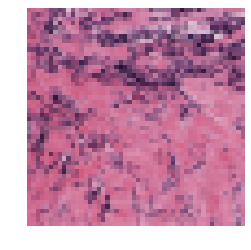

In [142]:
# Normalize data
x_list_normalized = x_list.astype('float32')/255

# split to train, test, val
X_train_original, X_test, y_train_original, y_test = train_test_split(x_list_normalized, y_list, stratify=y_list, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_original, y_train_original, stratify=y_train_original, test_size=0.2, random_state=42)

print('Reshaping...')

# reshape properly for NN input
X_train_reshaped = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_val_reshaped = X_val.reshape(X_val.shape[0], img_rows, img_cols, 3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

print('One Hot Encoding...')
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)
y_val_onehot = keras.utils.to_categorical(y_val, num_classes)

# plot image
plt.imshow(cv2.cvtColor(X_train_reshaped[0], cv2.COLOR_BGR2RGB)); plt.axis('off')

Next, let's take a peek at the data.

In [72]:
X_train_reshaped.shape

(12800, 50, 50, 3)

In [76]:
pd.Series(y_train).value_counts()

0    9160
1    3640
dtype: int64

Our dataset is imbalanced. To deal with this we will set class weights in our model and use ROC/AUC as our main metric (as well as keeping an eye on confusion matrix and accuracy.)

## Task 3.1

For our first task, we will create a model without residual connections with batch normalization. 

### Create/Compile Model

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# "BASE" MODEL
def baseline_model_cancer(optimizer="adam", hidden_size=32, summary=True):
    model = Sequential()
    model.add(Conv2D(hidden_size, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hidden_size, kernel_size=(3, 3),
                 activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile("adam", "binary_crossentropy", metrics=['accuracy'])
    if summary:
      model.summary()
    return model
  
def get_best_param(params, model_builder, param_name, other_param=None, X=X_train_reshaped, y=y_train_onehot, X_val=X_val_reshaped, y_val=y_val_onehot, y_val_predict=y_val, verbose=0, summary=False):
  for param in params:
    if param_name == 'size':
      model = model_builder(hidden_size=param, summary=summary)
    elif param_name == 'l2':
      model = model_builder(l2_param=param, hidden_size=other_param, summary=summary)
    else:
      print('no such parameter')
      break
    model.fit(X, y, batch_size=128, epochs=30, verbose=verbose, class_weight='balanced')
    score = model.evaluate(X_val, y_val)
    y_pred = model.predict_classes(X_val)
    print("Hidden Size: ", param)
    print("ROC-AUC Score: ", roc_auc_score(y_val_predict, y_pred))
    print("Validation accuracy: ", score[1])



#### Grid Search for Best Hidden Size Parameter

In [82]:
hidden_size_params = [32, 64, 128]
best_size_base = get_best_param(hidden_size_params, baseline_model_cancer, 'size', verbose=0, summary=False)

3200/3200 [==============================] - 1s 435us/step
Hidden Size:  32
ROC-AUC Score:  0.6887326647151975
Validation accuracy:  0.801875
3200/3200 [==============================] - 1s 456us/step
Hidden Size:  64
ROC-AUC Score:  0.7622630644464705
Validation accuracy:  0.8275
3200/3200 [==============================] - 2s 529us/step
Hidden Size:  128
ROC-AUC Score:  0.6515523777532513
Validation accuracy:  0.785625


### Model Evaluation

In [95]:
cnn = baseline_model_cancer(hidden_size=64) # 64 is best
history_cnn = cnn.fit(X_train_reshaped, y_train_onehot, class_weight='balanced',
                      batch_size=128, epochs=30, verbose=1)
score = cnn.evaluate(X_val_reshaped, y_val_onehot)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))
y_pred = cnn.predict_classes(X_val_reshaped)
print("ROC-AUC Score: ", roc_auc_score(y_val, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization_75 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 22, 22, 64)        36928     
_________________________________________________________________
batch_normalization_76 (Batc (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 7744)              0         
__________

### Learning Curve

Text(0.5, 1.0, 'Accuracy/Loss per Epoch')

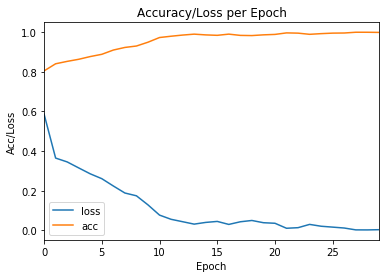

In [96]:
plot = pd.DataFrame(history_cnn.history)
plot.plot()
plt.xlabel("Epoch")
plt.ylabel("Acc/Loss")
plt.title("Accuracy/Loss per Epoch")

### Conclusion

Our results above indicate that our base classifier already works decently well, with an ROC of ~71% and accuracy of ~81% on the validation set. Furthermore, the learning curve looks good, since the model converges in its loss minimization.  However, we see above that the model might be overfitting.  Let us now compare this with augmented and a model with residual connections.

## Task 3.2

Next, we will augment the data using rotations, mirroring and other transformations to try to improve on our base model. Our method is as follows: we create augmentations (90, 180 degree rotations, mirroring, etc.) and then append them to our original dataset as a new image. This acts as 'feature engineering' for this dataset since we have made the model robust to augmentations. The drawback for this method would be that it would quadruple the size of our training data. 

In [0]:
def augment_data(X, y):
  X_aug = X.copy()
  y_aug = y.copy()
  for idx in tqdm(range(len(X_aug))):
    img = X_aug[0]
    aug = []
    img90 = np.rot90(img)
    img180 = np.rot90(img90)
    img270 = np.rot90(img180)
    imgflip = np.flip(img)
    aug.append(img90)
    aug.append(img180)
    aug.append(img270)
    aug.append(imgflip)
    X_aug = np.concatenate((X_aug, np.asarray(aug)), axis=0)

    if (y[i] == [1.0, 0.0]).all():
      for it in aug:
        y_aug = np.concatenate((y_aug, [[1.0, 0.0]]), axis=0)
    else:
      for it in aug:
        y_aug = np.concatenate((y_aug, [[0.0, 1.0]]), axis=0)

  return X_aug, y_aug

In [98]:
X_train_aug, y_train_aug = augment_data(X_train_reshaped, y_train_onehot)

Let's check if our dataset was indeed augmented and grew in size. From below, we see that it did! Let us now pass it into our classifier.

In [99]:
X_train_reshaped.shape

(12800, 50, 50, 3)

In [100]:
X_train_aug.shape

(64000, 50, 50, 3)

### Create/Compile Model

We will just use the model above since we are simply augmenting the data. 

### Model Evaluation

In [105]:
cnn = baseline_model_cancer(hidden_size=64) # 64 is best for base case
history_cnn = cnn.fit(X_train_aug, y_train_aug, class_weight='balanced',
                      batch_size=128, epochs=30, verbose=1)
score = cnn.evaluate(X_val_reshaped, y_val_onehot)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))
y_pred = cnn.predict_classes(X_val_reshaped)
print("ROC-AUC Score: ", roc_auc_score(y_val, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 48, 48, 64)        1792      
_________________________________________________________________
batch_normalization_87 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 22, 22, 64)        36928     
_________________________________________________________________
batch_normalization_88 (Batc (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 7744)              0         
__________

### Learning Curve

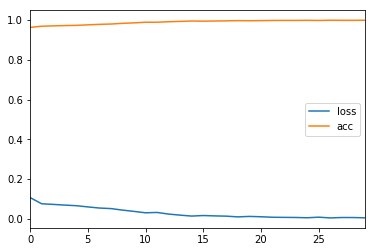

In [106]:
pd.DataFrame(history_cnn.history).plot()

### Conclusion

From the results above, we see that augmentation improved our ROC_AUC/accuracy slightly. It improved our ROC_AUC by 5% while accuracy by 1%. This improvement probably is because the model becomes more robust in these kinds of transformations to the data. 

## Task 3.3

For our final task, we will build a deeper model using residual connections. We will compare this  a deep model with one without a residual connection. To introduce a deep model, we will add more layers to the baseline model above. Note that we found that **using augmented data is worse for these deeper models**. 

### Without Residual Connections

#### Creating/Compiling the Model

In [0]:
def no_residual_model_cancer(optimizer="adam", hidden_size=64, summary=True):
    model = Sequential()
    model.add(Conv2D(hidden_size, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(hidden_size, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())  
    model.add(Conv2D(hidden_size, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(hidden_size, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hidden_size, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(hidden_size, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile("adam", "binary_crossentropy", metrics=['accuracy'])
    if summary:
      model.summary()
    return model

#### Model Evaluation

In [109]:
cnn = no_residual_model_cancer(hidden_size=32)
history_cnn = cnn.fit(X_train_aug, y_train_aug, class_weight='balanced',
                      batch_size=128, epochs=30, verbose=1)
score = cnn.evaluate(X_val_reshaped, y_val_onehot)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))
y_pred = cnn.predict_classes(X_val_reshaped)
print("ROC-AUC Score: ", roc_auc_score(y_val, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_89 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization_90 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_91 (Batc (None, 44, 44, 32)        128       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 42, 42, 32)        9248      
__________

#### Learning Curve

Text(0.5, 1.0, 'Accuracy/Loss per Epoch')

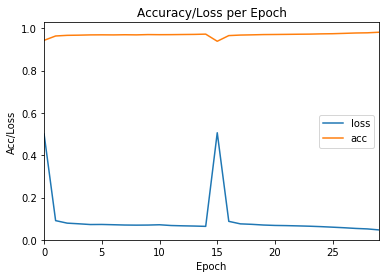

In [110]:
pd.DataFrame(history_cnn.history).plot()
plt.xlabel("Epoch")
plt.ylabel("Acc/Loss")
plt.title("Accuracy/Loss per Epoch")

### With Residual Connections

#### Creating/Compiling the Model

In [0]:
def residual_model_cancer(optimizer="adam", hidden_size=64, summary=True, residual=True):
    inputs = Input(shape=input_shape)
    layer_1 = Conv2D(hidden_size, (3, 3), padding='same', activation='relu')(inputs)
    layer_1 = BatchNormalization()(layer_1)

    layer_2 = Conv2D(hidden_size, (3, 3), padding='same', activation='relu')(layer_1)
    layer_2 = BatchNormalization()(layer_2)
    
    layer_3 = Conv2D(hidden_size, (3, 3), padding='same', activation='relu')(layer_2)
    layer_3 = BatchNormalization()(layer_3)
    
    skip_1 = keras.layers.add([layer_1, layer_3])
    
    pool_1 = MaxPooling2D(pool_size=(2,2))(skip_1)

    layer_4 = Conv2D(hidden_size, (3, 3), padding='same', activation='relu')(pool_1)
    layer_4 = BatchNormalization()(layer_4)

    layer_5 = Conv2D(hidden_size, (3, 3), padding='same', activation='relu')(layer_4)
    layer_5 = BatchNormalization()(layer_5)

    layer_6 = Conv2D(hidden_size, (3, 3), padding='same', activation='relu')(layer_5)
    layer_6 = BatchNormalization()(layer_6)
    
    skip_2 = keras.layers.add([layer_4, layer_6])

    pool_1 = MaxPooling2D(pool_size=(2,2))(skip_2)

    x = Flatten()(pool_1)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile("adam", "binary_crossentropy", metrics=['accuracy'])
    if summary:
      model.summary()
    return model

#### Model Evaluation

In [147]:
cnn = residual_model_cancer(hidden_size=64)
history_cnn = cnn.fit(X_train_reshaped, y_train_onehot, class_weight='balanced',
                      batch_size=128, epochs=30, verbose=1)
score = cnn.evaluate(X_val_reshaped, y_val_onehot)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))
y_pred = cnn.predict(X_val_reshaped)
y_pred_process = []
for i in range(len(y_pred)):
  if y_pred[i][0] > y_pred[i][1]:
    y_pred_process.append(0)
  else:
    y_pred_process.append(1)
print("ROC-AUC Score: ", roc_auc_score(y_val, y_pred_process))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred_process))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 50, 50, 64)   1792        input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_187 (BatchN (None, 50, 50, 64)   256         conv2d_194[0][0]                 
__________________________________________________________________________________________________
conv2d_195 (Conv2D)             (None, 50, 50, 64)   36928       batch_normalization_187[0][0]    
__________________________________________________________________________________________________
batch_norm

#### Learning Curve

Text(0.5, 1.0, 'Accuracy/Loss per Epoch')

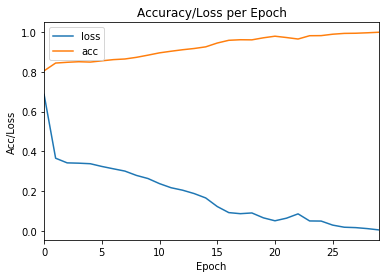

In [148]:
pd.DataFrame(history_cnn.history).plot()
plt.xlabel("Epoch")
plt.ylabel("Acc/Loss")
plt.title("Accuracy/Loss per Epoch")

### Conclusion

From the results above, we can see that the deep network works best in regards to accuracy and ROC AUC performance when we use ResNets. Without ResNet connections, the metrics perform significantly worse and with unstable learning curves.

## Best Model Performance on the Test Set

From the results above, let us now use the best performing model (deep NN with ResNet) and evaluate it using the hold-out/test set. From the results below, we see that our best model did quite well! With an accuracy of **83.8%** and ROC AUC of **78.4%**. 

### Metrics

In [157]:
score = cnn.evaluate(X_test, y_test_onehot)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))
y_pred = cnn.predict(X_test)
y_pred_process = []
for i in range(len(y_pred)):
  if y_pred[i][0] > y_pred[i][1]:
    y_pred_process.append(0)
  else:
    y_pred_process.append(1)
print("ROC-AUC Score: ", roc_auc_score(y_test, y_pred_process))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_process))

4000/4000 [==============================] - 2s 437us/step
Test loss: 1.067
Test Accuracy: 0.838
ROC-AUC Score:  0.7840591036396496
Confusion Matrix: 
 [[2601  262]
 [ 387  750]]


## Best Model Performance on "Full"  Dataset

Finally, let's use our best model to be evaluated on a larger set of the full dataset. 

### Load Data, Preprocess

In [0]:
x_full, y_full = retrieveImages('../content/**/**/*.png')

# Normalize data
x_full = x_full.astype('float32')/255

# split to train, test, val
X_train_original, X_test, y_train_original, y_test = train_test_split(x_full, y_full, stratify=y_list, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_original, y_train_original, stratify=y_train_original, test_size=0.2, random_state=42)

print('Reshaping...')

# reshape properly for NN input
X_train_reshaped = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_val_reshaped = X_val.reshape(X_val.shape[0], img_rows, img_cols, 3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

print('One Hot Encoding...')
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)
y_val_onehot = keras.utils.to_categorical(y_val, num_classes)

# plot image
plt.imshow(cv2.cvtColor(X_train_reshaped[0], cv2.COLOR_BGR2RGB)); plt.axis('off')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-304-93413203682c>", line 1, in <module>
    x_full, y_full = retrieveImages('../content/**/**/*.png')
  File "<ipython-input-303-266badfd4678>", line 27, in retrieveImages
    if file_location in class_zero:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_ge

KeyboardInterrupt: ignored

### Model Fitting/Evaluation

In [0]:
cnn = residual_model_cancer(hidden_size=64)
history_cnn = cnn.fit(X_train_reshaped, y_train_onehot, class_weight='balanced',
                      batch_size=128, epochs=30, verbose=1)
score = cnn.evaluate(X_val_reshaped, y_val_onehot)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))
y_pred = cnn.predict(X_val_reshaped)
y_pred_process = []
for i in range(len(y_pred)):
  if y_pred[i][0] > y_pred[i][1]:
    y_pred_process.append(0)
  else:
    y_pred_process.append(1)
print("ROC-AUC Score: ", roc_auc_score(y_val, y_pred_process))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred_process))